In [1]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import data
import numpy as np
import yfinance as yf
from datetime import date, timedelta, time

In [3]:
symbol = "ROSSELLIND.NS"
start_time = date.today() - timedelta(days=40)
end_time = date.today()

In [4]:
fivemin = yf.download(symbol, interval='5m', start=start_time, end=end_time, index_col=0, parse_dates=True)

[*********************100%***********************]  1 of 1 completed


In [5]:
daily_start_time = date.today() - timedelta(days=200)
daily_end_time = date.today()
daily = yf.download(symbol, start=daily_start_time, end=daily_end_time, index_col=0, parse_dates=True)

[*********************100%***********************]  1 of 1 completed


In [6]:
import ta
daily['rsi'] = ta.momentum.rsi(daily['Adj Close'])

In [7]:
df = fivemin

In [8]:
# fivemin
df.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-03-17 09:15:00+05:30,164.800003,164.800003,159.699997,163.899994,163.899994,0
2022-03-17 09:20:00+05:30,163.949997,164.449997,163.050003,163.050003,163.050003,6386
2022-03-17 09:25:00+05:30,163.050003,163.399994,162.199997,162.199997,162.199997,1447
2022-03-17 09:30:00+05:30,162.199997,162.199997,160.199997,160.199997,160.199997,2994
2022-03-17 09:35:00+05:30,160.500000,161.699997,160.500000,161.649994,161.649994,3237


In [9]:
df['5ema'] = df['Close'].rolling(5).mean()

In [10]:
df = df.dropna()

In [11]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,5ema
Datetime,,,,,,,
2022-04-25 15:05:00+05:30,206.399994,207.000000,206.149994,206.350006,206.350006,2184,206.450000
2022-04-25 15:10:00+05:30,206.350006,206.750000,206.149994,206.600006,206.600006,352,206.570001
2022-04-25 15:15:00+05:30,206.550003,207.800003,206.149994,207.000000,207.000000,1114,206.680002
2022-04-25 15:20:00+05:30,206.149994,207.699997,206.100006,207.100006,207.100006,3620,206.700003
2022-04-25 15:25:00+05:30,207.100006,207.100006,205.100006,206.649994,206.649994,3451,206.740002


In [12]:
from datetime import datetime
# add previous day rsi to each row in the df
shifted_daily_rsi = daily['rsi'].shift(1)

df['prev_daily_rsi'] = np.nan
for daily_idx in shifted_daily_rsi.index:
    for df_idx in df.index:
        if df_idx.date() == daily_idx.date():
            df['prev_daily_rsi'] = shifted_daily_rsi[daily_idx]


/Users/prince/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/prince/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/prince/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [13]:
# entry candle is the one which is above 5 ema and doesnt touch 5ema line.
df['entry_candle'] = np.nan
# now we need to look for a candle which crosses the entry candle low, that will be the buy price.
df['signal'] = np.nan
df['buy_price'] = np.nan
df['sell_price'] = np.nan

entry_candle_index = -1
in_trade = False
length_of_signal_candle = -1
buy_price = -1

for idx in df.index:
    
    if not in_trade:
        # now we have found the entry candle 
        # we are looking for a entry in a trade now.
        # as soon as the candle crosses the low of entry_candle, we enter the trade.
        if entry_candle_index != -1:
            if df['Low'][idx] < df['Low'][entry_candle_index]:
                df['signal'][idx] = 1
                length_of_signal_candle = df['High'][idx] - df['Low'][idx]
                buy_price = df['Low'][entry_candle_index]
                df['buy_price'][idx] = df['Low'][entry_candle_index]
                in_trade = True

                
        # this is a trigger condition, it sets the entry_candle_idx which then our algo uses of 
        # to enter the trade.
        
        # we are not in a trade.
        # check when the candle gets created above the 5ema line.
        # this will update the entry-candle index to the next candle if the condition still meets.
        
        # dont make an entry if the rsi on the daily candle of the previous day is below 30
        # only when the daily rsi is greater than 40, think about shorting else skip
        if df['5ema'][idx] < df['Low'][idx] and df['prev_daily_rsi'][idx] > 60: 
            entry_candle_index = idx

    else:
        # if we are in a trade
        # either we hit SL
        if df['High'][idx] >= buy_price + length_of_signal_candle:
            # we are closing the trade at closing price of the candle
            # df['sell_price'][idx] = df['Close'][idx] # buy_price + length_of_signal_candle -> when SL is touched...
            
            # close the price as soon as the SL is hit
            df['sell_price'][idx] = buy_price + length_of_signal_candle
            
            # set variables to close the trade.
            df['signal'][idx] = -1
            length_of_signal_candle = -1
            buy_price = -1
            entry_candle_index = -1
            in_trade = False
            
        # or we hit the target.
        # currently the strategy exits the position when 1:2 trade is reached.
        elif df['Low'][idx] <= buy_price - 2 * length_of_signal_candle:
            # uncomment the below line to exit at the close of candle which touches the target.
#             df['sell_price'][idx] = df['Close'][idx] # buy_price - 2 * length_of_signal_candle  -> same as above
            df['sell_price'][idx] = buy_price - 2 * length_of_signal_candle
    
            # set variables to close the trade.
            df['signal'][idx] = -1
            length_of_signal_candle = -1
            entry_candle_index = -1
            buy_price = -1
            in_trade = False
            
        # exit from the strategy if the day has ended @3:!5
        elif idx.time() == time(hour=15, minute=15):
            df['sell_price'][idx] = df['Close'][idx]
            
            # set variables to close the trade.
            df['signal'][idx] = -1
            length_of_signal_candle = -1
            entry_candle_index = -1
            buy_price = -1
            in_trade = False
        

/Users/prince/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/var/folders/1r/4l552nf17t77rvcg5njtz4540000gn/T/ipykernel_68391/2582055612.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][idx] = 1
/var/folders/1r/4l552nf17t77rvcg5njtz4540000gn/T/ipykernel_68391/2582055612.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [14]:
tradesdf = df[(df.signal == 1) | (df.signal == -1)]
tradesdf.tail(10)

,Open,High,Low,Close,Adj Close,Volume,5ema,prev_daily_rsi,entry_candle,signal,buy_price,sell_price
Datetime,,,,,,,,,,,,
2022-04-25 12:00:00+05:30,208.300003,208.300003,207.750000,207.750000,207.750000,119,207.380002,67.133673,NaN,1.0,207.800003,NaN
2022-04-25 12:15:00+05:30,207.000000,207.000000,206.500000,206.500000,206.500000,1174,207.530002,67.133673,NaN,-1.0,NaN,206.699997
2022-04-25 13:00:00+05:30,205.850006,205.850006,205.649994,205.649994,205.649994,118,205.539999,67.133673,NaN,1.0,205.800003,NaN
2022-04-25 13:05:00+05:30,206.199997,206.449997,206.199997,206.449997,206.449997,1042,205.700000,67.133673,NaN,-1.0,NaN,206.000015
2022-04-25 13:25:00+05:30,207.350006,207.350006,206.850006,206.850006,206.850006,182,206.759998,67.133673,NaN,1.0,207.000000,NaN
2022-04-25 13:40:00+05:30,206.500000,206.500000,206.000000,206.000000,206.000000,639,206.660001,67.133673,NaN,-1.0,NaN,206.000000
2022-04-25 14:10:00+05:30,206.600006,206.600006,206.399994,206.399994,206.399994,372,206.429999,67.133673,NaN,1.0,206.699997,NaN
2022-04-25 14:15:00+05:30,206.050003,206.649994,206.000000,206.649994,206.649994,1059,206.539996,67.133673,NaN,-1.0,NaN,206.299973
2022-04-25 15:00:00+05:30,206.949997,206.949997,206.449997,206.449997,206.449997,205,206.409998,67.133673,NaN,1.0,206.550003,NaN


In [15]:
# because this is a shorting trade.
tradesdf['pnl'] = tradesdf.buy_price.shift(1) - tradesdf.sell_price

/Users/prince/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [16]:
total_trades = len(tradesdf.pnl.dropna())
total_trades

127

In [17]:
winning_trades = tradesdf[tradesdf.pnl > 0]
loosing_trades = tradesdf[tradesdf.pnl <= 0]
winning_prob = len(winning_trades) / total_trades
winning_prob

0.4409448818897638

In [18]:
avg_winning_trade_pnl = winning_trades.pnl.sum() / len(winning_trades)
print(avg_winning_trade_pnl)
avg_loosing_trade_pnl = loosing_trades.pnl.sum() / len(loosing_trades)
print(avg_loosing_trade_pnl)

1.5946437290736608
-1.0352116974306778


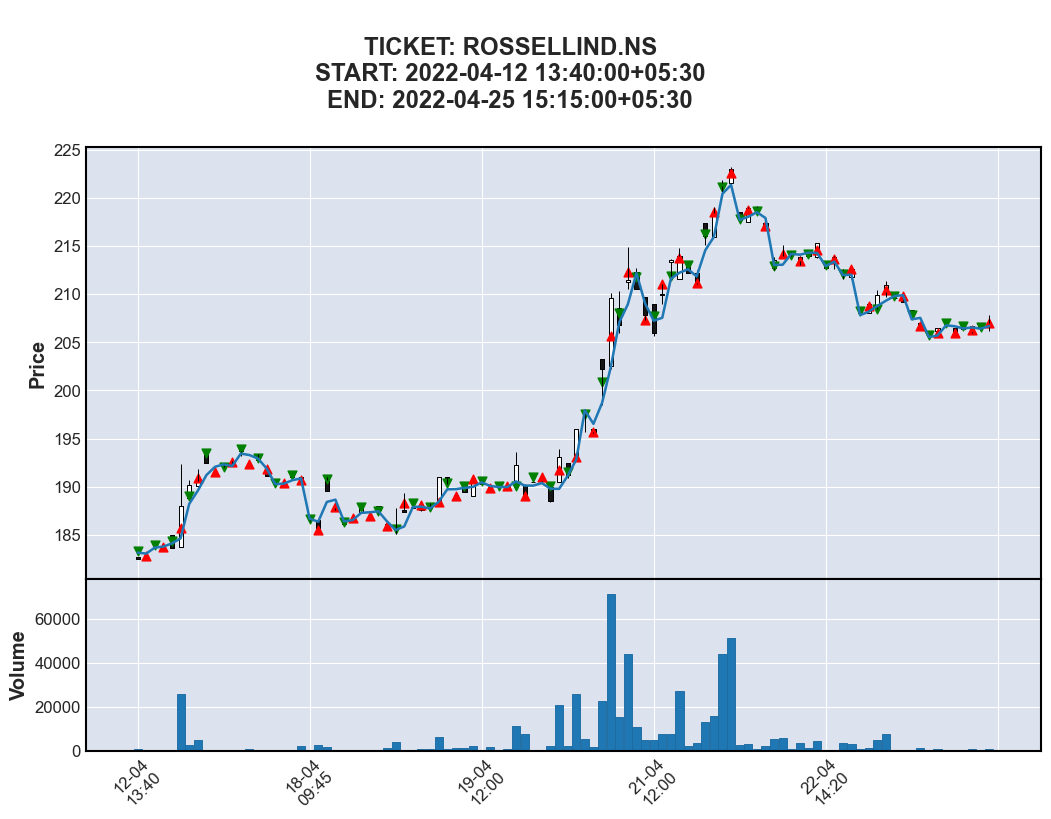

In [19]:
import mplfinance as mpf

def plot(df):
    apds = [
        mpf.make_addplot(df['5ema']),
#         mpf.make_addplot(df['signal'] ,type='scatter', markersize=100, marker='v'),
        mpf.make_addplot(df['buy_price'] ,type='scatter', markersize=40, marker='v', color='g'),
        mpf.make_addplot(df['sell_price'] ,type='scatter', markersize=40, marker='^', color='r')
    ]
    
    mpf.plot(df, type='candle', volume=True, addplot=apds, figratio=(20,13), figscale=1.5, 
            title='\nTICKET: %s\nSTART: %s\nEND: %s' % (symbol, df.index[0], df.index[-1]), 
             datetime_format='%d-%m\n%H:%M')
    
    

plot(tradesdf.tail(100))